# Sagemaker Edge Model Trainer
## GluonCV on SageMaker Training

This notebook has to be executed on a SageMaker notebook instance. It will easily help you train a model straight from the completed output of a Sagemaker Ground Truth labelling job, with no prior knowledge required.

*If you are asked to choose a kernel for this notebook, choose "conda_mxnet_p36" or "MXNet 1.6 Python 3.6"*


## Configurables

There is only one required configurable for this notebook, and that's the name of your Sagemaker Ground Truth Labelling Job which should be completed already. There are however, some optional configurables in the next cell should you wish to get a little adventurous.

In [1]:
sm_groundtruth_labelling_job_name = "awsdltv2FinalApproach"

# This script will automatically crawl this job for all the related manifest files to derrive 
# the remaining items of configuration about your training data, labels and S3 paths.


And here are the optional configurables should you wish to customise your training

In [2]:
training_epochs = 20
learning_rate = 0.001
training_instance_type='ml.p2.8xlarge'

That's it! From here on in, we will annotate code of interest with code comments for your information. Continue through all the steps to finish training your Sagemaker model.

## Let's start training.

First we will install the dependencies needed

In [3]:
!pip install gluoncv==0.8.0
!pip install opencv-python

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


Now we will declare our imports

In [4]:
import sagemaker
import mxnet as mx
import matplotlib.pyplot as plt
import gluoncv as gcv
import glob
import math
import numpy as np
import json
import cv2
import os
import tarfile
import boto3
import re
from sagemaker.debugger import Rule, rule_configs
from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from gluoncv import model_zoo, data, utils
import boto3

We will determine the Sagemaker Service role

In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

Now it's time to start automatically resolving information such as the training data manifest, output ground truth annotations manifest, the class labels used in training and the label attribute name for the training job (not always the same as the name you gave the job when you created it)

In [6]:
#Create a SageMaker Boto3 client to do some lookups
sm_client = boto3.client('sagemaker')

#query the SM GT Labelling Job by Name
response = sm_client.describe_labeling_job(
    LabelingJobName=sm_groundtruth_labelling_job_name
)

sm_gt_manifest_file_s3_path = response["LabelingJobOutput"]["OutputDatasetS3Uri"]
sm_gt_source_frames_manifest_s3_path = response["InputConfig"]["DataSource"]["S3DataSource"]["ManifestS3Uri"]
sm_gt_label_category_config_s3_path = response["LabelCategoryConfigS3Uri"]

source_training_frames_s3_prefix = '/'.join(sm_gt_source_frames_manifest_s3_path.split('/')[:-1])
ground_truth_manifest_s3_prefix = '/'.join(sm_gt_manifest_file_s3_path.split('/')[:-1])

# define an s3 client for some s3 operations
s3_client = boto3.client('s3')

#let's grab the config json file that contains all our labels for this Ground Truth job and build our classes array
sm_gt_classes = []

_bucketName = sm_gt_label_category_config_s3_path.split('/')[2]
_keyPath = '/'.join(sm_gt_label_category_config_s3_path.split('/')[3:])
response = s3_client.get_object(
    Bucket=_bucketName,
    Key=_keyPath
)
_label_cfg_file = json.loads(response['Body'].read().decode('utf-8'))

for label in _label_cfg_file["labels"]:
    sm_gt_classes.append(label["label"])
            
#Now we need to grab the manifest file from S3 to determine the "Label Attribute Name" for this labelling job, as it can be different from what the name is in Ground Truth
_bucketName = sm_gt_manifest_file_s3_path.split('/')[2]
_keyPath = '/'.join(sm_gt_manifest_file_s3_path.split('/')[3:])
response = s3_client.get_object(
    Bucket=_bucketName,
    Key=_keyPath
)
manifest_file_body = response['Body'].read().decode('utf-8')
manifest_line_0 = manifest_file_body.split('\n')[0]
_m_obj = json.loads(manifest_line_0)

#We have now found the label attribute name for this manifest file.
labelAttributeName = list(_m_obj.keys())[1]


We will grab the preview image from your training set and overlay the applicable detection regions found by your annotators to preview the datasets and make sure we're about to start training with the right data.

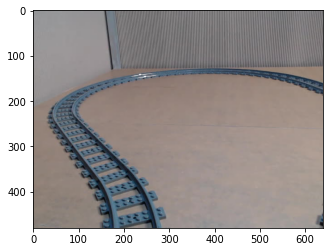

In [7]:
image_info = []

lines = manifest_file_body.strip().split('\n')
for line in lines:
    image_info.append(json.loads(line))

info = image_info[0]

class_map = info[f'{labelAttributeName}-metadata']['class-map']
img_bucket = info['source-ref'].split('/')[2]
img_filename = info['source-ref'].split('/')[-1]
img_s3_path = "/".join(info['source-ref'].split('/')[3:])

s3_client.download_file(img_bucket, img_s3_path, "source-ref/"+img_filename)

image = plt.imread(os.path.join("source-ref",img_filename))
saved_image = image.copy() #Save an unmanipulated reference to the image
boxes = info[labelAttributeName]['annotations']
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

Last but not least, it's time to create our MXNet Estimator and submit the job for training with Sagemaker. 

In [ ]:
mxnet_estimator = MXNet(entry_point='estimator.py',
                        source_dir='entry_point',
                        role=role,
                        train_instance_type=training_instance_type,
                        train_instance_count=1,
                        sagemaker_session=sagemaker_session,
                        framework_version='1.6.0', 
                        py_version='py3',
                        hyperparameters={
                            "task-name": labelAttributeName,
                            "classes-csv": ",".join(sm_gt_classes),
                            "target-epochs": training_epochs,
                            "learning-rate": learning_rate
                        })

mxnet_estimator.fit({'train': source_training_frames_s3_prefix, 'labels': ground_truth_manifest_s3_prefix})

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-01-13 14:15:43 Starting - Starting the training job...
2022-01-13 14:15:45 Starting - Launching requested ML instancesProfilerReport-1642083343: InProgress
.........
2022-01-13 14:17:35 Starting - Preparing the instances for training...............
2022-01-13 14:20:11 Downloading - Downloading input data
2022-01-13 14:20:11 Training - Downloading the training image...
2022-01-13 14:20:36 Training - Training image download completed. Training in progress.2022-01-13 14:20:34,782 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-13 14:20:34,863 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"classes-csv":"legotrain","learning-rate":0.001,"target-epochs":20,"task-name":"awsdltv2FinalApproach"}', 'SM_USER_ENTRY_POINT': 'estimator.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_i